In [6]:
from matplotlib import pyplot as plt
import jax
import jax.numpy as jnp
import jax.random as jr
import numpy
from scipy.optimize import minimize
import numpyro.distributions as dist
from numpyro import infer
import os
import alphacen as ac
import utils

os.chdir('/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/toliman-phd')

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = 'monospace'
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 120
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

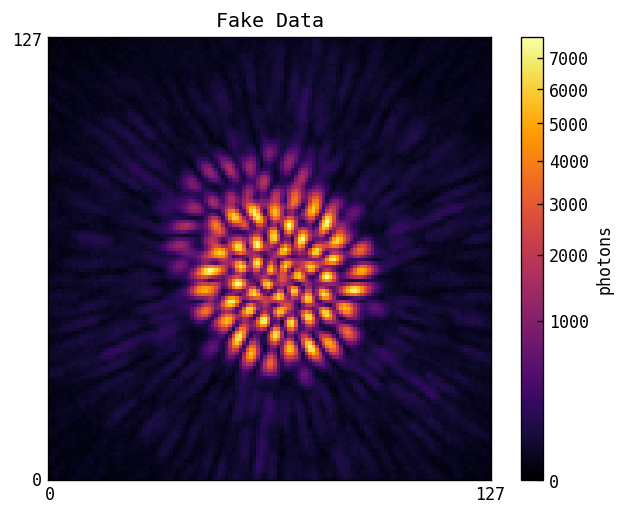

PA: 2.63
Separation: 4.45
log10(Flux): 6.49
Contrast: 4.48
____
Jitter radius: 0.44
Jitter angle: 0.74


In [2]:
fakedata_obj = ac.AlphaCenPSF(mask_dir='data/toliman_pupil.npy', n_wavels=50)

# physical parameters
fakedata_obj.pa = jr.uniform(jr.PRNGKey(0))*360  # position angle in degrees
fakedata_obj.sep = jnp.abs(8 + 3*jr.normal(jr.PRNGKey(1)))  # binary separation in arcseconds
fakedata_obj.flux = (6.152e7 / 10 / 2) + 1e5 * jnp.abs(jr.normal(jr.PRNGKey(2)))  # AVERAGE flux of the two stars per frame
fakedata_obj.contrast = jnp.abs(3.372873 + jr.normal(jr.PRNGKey(3)))  # flux contrast from V band magnitudes

# instrument
optics, source = fakedata_obj.GetInstrument()
idealPSF = optics.model(source)
jitfunc = ac.get_jitter_func(optics, source)

# jitter parameters
jitter_rad = jnp.abs(0.5 + 0.3 * jr.normal(jr.PRNGKey(0)))
jitter_angle = jr.uniform(jr.PRNGKey(1))*360
jitPSF = jitfunc(rad=jitter_rad, angle=jitter_angle, npsf=50)
noisePSF = ac.add_noise_to_psf(jitPSF)
utils.PlotSqrtPSF(noisePSF, title='Fake Data')

print(f'PA: {jnp.deg2rad(fakedata_obj.pa):.2f}')
print(f'Separation: {fakedata_obj.sep:.2f}')
print(f'log10(Flux): {jnp.log10(fakedata_obj.flux):.2f}')
print(f'Contrast: {fakedata_obj.contrast:.2f}')
print('____')
print(f'Jitter radius: {jitter_rad:.2f}')
print(f'Jitter angle: {jnp.deg2rad(jitter_angle):.2f}')

fake_data = jnp.abs(noisePSF) # TODO DONT TAKE ABSOLUTE VALUE HERE

In [4]:
def build_model_psf(theta):
    """
    Function for building a model PSF from a set of parameters.
    """
    # unpacking parameters
    pa, sep, logF, cont, rad, ang = theta

    # building model
    psf_obj = ac.AlphaCenPSF(mask_dir='data/toliman_pupil.npy', n_wavels=3)

    # physical parameters
    psf_obj.pa = jnp.rad2deg(pa)  # position angle in degrees
    psf_obj.sep = sep  # binary separation in arcseconds
    psf_obj.flux = 10 ** logF  # AVERAGE flux of the two stars per frame
    psf_obj.contrast = cont  # flux contrast from V band magnitudes

    # instrument
    optics, source = psf_obj.GetInstrument()
    jitfunc = ac.get_jitter_func(optics, source)
    model = jitfunc(rad=rad, angle=jnp.rad2deg(ang), npsf=3)

    return model

def log_likelihood(theta, data):
    """Function for calculating the natural log of the likelihood function."""

    # parameters
    model = build_model_psf(theta)
    error = jnp.sqrt(data)  # TODO can you get negative values on a detector?
    error = jnp.where(error==0, 1, error)  # TODO DONT DO THIS

    # calculating natural log of likelihood function
    ln_likelihood = -0.5 * jnp.sum(((data - model)/error) ** 2 + jnp.log(2*jnp.pi*error**2))

    return ln_likelihood

def log_prior(theta):
    """Function for calculating the natural log of the prior function."""
    pa, sep, logF, cont, rad, ang = theta

    pa_in_bounds = np.logical_and(0 < pa, pa < 2 * np.pi)
    sep_in_bounds = np.logical_and(0.0 < sep, sep < 20.0)
    logF_in_bounds = np.logical_and(6 < logF, logF < 8.5)
    cont_in_bounds = np.logical_and(1.0 < cont, cont < 10.0)
    rad_in_bounds = np.logical_and(0.0 < rad, rad < 5.0)
    ang_in_bounds = np.logical_and(0.0 < ang, ang < 2 * np.pi)

    in_bounds = np.logical_and.reduce((pa_in_bounds, sep_in_bounds, logF_in_bounds, cont_in_bounds, rad_in_bounds, ang_in_bounds))

    return np.where(in_bounds, 0.0, -np.inf)



def log_probability(theta, data):
    """Function for calculating the natural log of the posterior function."""
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    else: return lp + log_likelihood(theta, data)

# Finding the Maximum Likelihood Estimate

In [7]:
# %%timeit
nll = lambda *args: -log_likelihood(*args)
initial = numpy.array([numpy.deg2rad(fakedata_obj.pa), fakedata_obj.sep, numpy.log10(fakedata_obj.flux), fakedata_obj.contrast, jitter_rad, numpy.deg2rad(jitter_angle)] + 0.1 * numpy.random.randn(6))
soln = minimize(nll, initial, args=numpy.array((fake_data,)))
theta_ml = soln.x

[2.54169275 4.51831405 6.27848702 4.50869413 0.43971413 0.81592872]


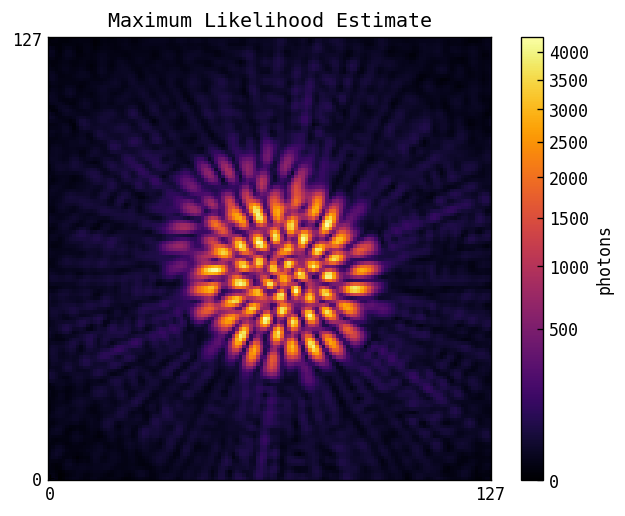

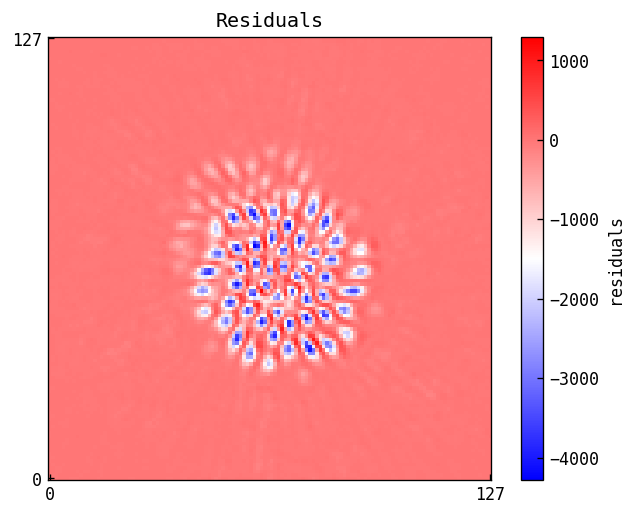

In [8]:
print(theta_ml)
utils.PlotSqrtPSF(build_model_psf(theta_ml), title='Maximum Likelihood Estimate')

fig, ax = plt.subplots()
c = ax.imshow(build_model_psf(theta_ml) - fake_data, cmap='bwr')
ax.set(
        title='Residuals',
        xticks=[0, fake_data.shape[0] - 1],
        yticks=[0, fake_data.shape[1] - 1],
        )
fig.colorbar(c, ax=ax, label='residuals')
plt.show()

# MCMC

In [167]:
# Define the initial values for the MCMC sampler
initial_values = [
    jr.uniform(jr.PRNGKey(0), minval=0.0, maxval=2*np.pi),  # pa
    jr.uniform(jr.PRNGKey(1), minval=0.0, maxval=10.0),  # sep
    jr.uniform(jr.PRNGKey(2), minval=0.0, maxval=10.0),  # logF
    jr.uniform(jr.PRNGKey(3), minval=0.0, maxval=10.0),  # cont
    jr.uniform(jr.PRNGKey(4), minval=0.0, maxval=10.0),  # rad
    jr.uniform(jr.PRNGKey(5), minval=0.0, maxval=2*np.pi)  # ang
]

num_warmup=100
num_samples=500

# Define the NUTS sampler
nuts_kernel = NUTS(log_probability)

# Define the MCMC sampler
mcmc = MCMC(nuts_kernel, num_warmup=num_warmup, num_samples=num_samples)

# Run the MCMC sampler
mcmc.run(jr.PRNGKey(0), initial_values, fake_data)

# Get the posterior samples
posterior_samples = mcmc.get_samples()

AttributeError: 'PjitFunction' object has no attribute 'reduce'

7.5


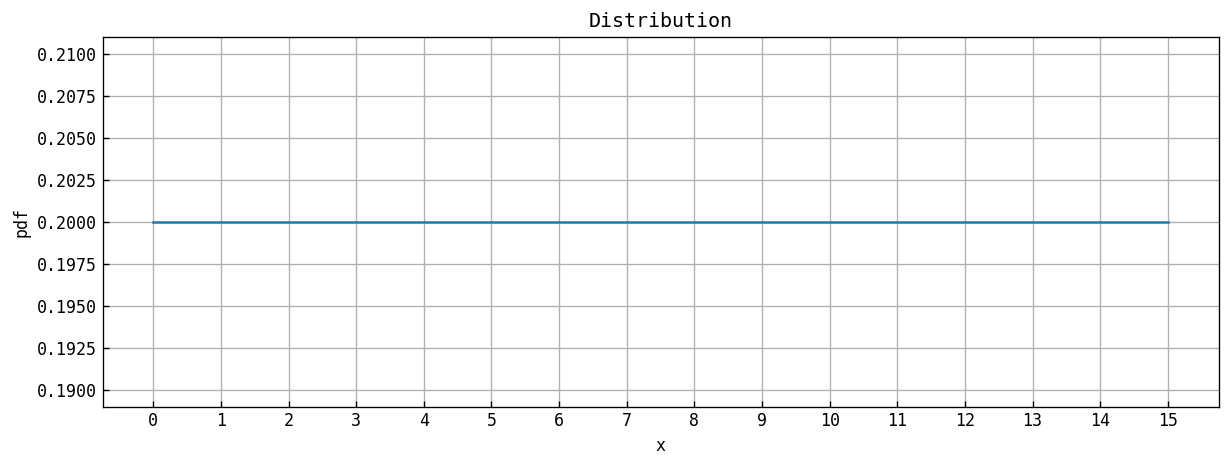

0.19999999


In [166]:
x = numpy.linspace(0, 15, 1000)
# y = numpy.exp(dist.Normal(1, 1).log_prob(x))
disty = dist.Uniform(low=5., high = 10.)
y = numpy.exp(disty.log_prob(x))

print(disty.mean)

plt.figure(figsize=(12, 4))
plt.xticks(range(0,16))
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('pdf')
plt.title('Distribution')
plt.grid()
plt.show()

print(np.exp(disty.log_prob(110.)))

In [99]:
dist.Beta?